In [2]:
path = '/Users/jaeyeobjeong/Desktop/포트폴리오/프로젝트/소비예측_경진대회/data'

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [10]:
train = pd.read_csv(f'{path}/train_0504.csv')
test = pd.read_csv(f'{path}/test_0504.csv')

In [11]:
ohe_features = ['Education', 'Marital_Status']

train_ohe, test_ohe = pd.DataFrame(), pd.DataFrame()
for feat in ohe_features:
    # 라벨 인코더 생성
    encoder = OneHotEncoder()

    # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
    train_oh_encoded = encoder.fit_transform(train[feat].values.reshape(-1,1)).toarray()
    test_oh_encoded = encoder.transform(test[feat].values.reshape(-1,1)).toarray()

    train_oh = pd.DataFrame(train_oh_encoded, 
                 columns = [feat + '_' + value for value in train[feat].unique()])
    test_oh = pd.DataFrame(test_oh_encoded, 
                 columns = [feat + '_' + value for value in train[feat].unique()])
    
    train_ohe = pd.concat([train_ohe, train_oh], axis = 1)
    test_ohe = pd.concat([test_ohe, test_oh], axis = 1)

In [12]:
train = pd.concat([train, train_ohe], axis = 1)
test = pd.concat([test, test_ohe], axis = 1)

In [13]:
train_ohe.columns

Index(['Education_Master', 'Education_Graduation', 'Education_Basic',
       'Education_PhD', 'Education_2n Cycle', 'Marital_Status_Together',
       'Marital_Status_Single', 'Marital_Status_Married',
       'Marital_Status_Widow', 'Marital_Status_Divorced',
       'Marital_Status_Alone', 'Marital_Status_YOLO', 'Marital_Status_Absurd'],
      dtype='object')

## Validation

### Set X, y

In [14]:
# xgboost는 catboost보다 범주형 변수에 대한 fit이 떨어지기 때문에, 범주형 변수를 제외하고 학습 진행

in_xgb_features = ['Income', 'NumWebVisitsMonth', 'NumPurchases', 
                     'register_age', 'shopping_interval',
                     'diff_kid_teen',
                     'Sum_AcceptedCmp', 
                     'Complain',
                     'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [15]:
X = train[in_xgb_features]
y = np.sqrt(train['target'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Cross Validation

In [17]:
val_xgb = XGBRegressor(random_state = 0)
val_lgb = LGBMRegressor(boosting_type = 'gbdt', random_state = 0)
val_rf = RandomForestRegressor(random_state = 0)

In [20]:
scores_xgb = cross_val_score(val_xgb, X_train, y_train, cv = 5)
scores_lgb = cross_val_score(val_lgb, X_train, y_train, cv = 5)
scores_rf = cross_val_score(val_rf, X_train, y_train, cv = 5)

print('Non Sampling XGB model :', scores_xgb, 'Mean :', np.mean(scores_xgb))
print('Non Sampling LGBM model :', scores_lgb, 'Mean :', np.mean(scores_lgb))
print('Non Sampling rf model :', scores_rf, 'Mean :', np.mean(scores_rf))

Non Sampling XGB model : [0.91441783 0.8978083  0.92016949 0.92915891 0.92904592] Mean : 0.9181200897629637
Non Sampling LGBM model : [0.92063007 0.91513141 0.92068862 0.94043723 0.93500408] Mean : 0.9263782816196727
Non Sampling rf model : [0.91364048 0.920958   0.91280933 0.92328927 0.93356579] Mean : 0.920852574732843


### Scoring by NMAE

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    
    return score

In [22]:
val_xgb = XGBRegressor(random_state = 0)
val_xgb.fit(X_train, y_train)
xgb_pred = val_xgb.predict(X_test) # y예측

print(f'모델 NMAE : {nmae(y_test**2,xgb_pred**2)}') #if sqrt processing y
#print(f'모델 NMAE : {nmae(2**(y_test),2**(xgb_pred))}') #if log2 processing y
#print(f'모델 NMAE : {nmae(y_test,xgb_pred)}')

모델 NMAE : 0.15800960889139296


In [26]:
val_lgb = LGBMRegressor(random_state = 0)
val_lgb.fit(X_train, y_train)
lgb_pred = val_lgb.predict(X_test) # y예측

print(f'모델 NMAE: {nmae(y_test**2,lgb_pred**2)}')
#print(f'모델 NMAE: {nmae(2**(y_test),2**(lgb_pred))}')
#print(f'모델 NMAE: {nmae(y_test,lgb_pred)}')

모델 NMAE: 0.1758877155924433


In [25]:
val_rf = RandomForestRegressor(random_state = 0)
val_rf.fit(X_train, y_train)
rf_pred = val_rf.predict(X_test) # y예측

print(f'모델 NMAE: {nmae(y_test**2,rf_pred**2)}') #if np.sqrt(y_test)
#print(f'모델 NMAE: {nmae(2**(y_test),2**(rf_pred))}') #if np.log2(y_test)
#print(f'모델 NMAE: {nmae(y_test,rf_pred)}')

모델 NMAE: 0.18071805464418772


- 정확도 기반의 CV에서는 LGBM > RandomForest > XGB 순의 성능을 보임.
- 하지만, 대회 평가지표인 NMAE에서 XGB > LGBM > RF 순의 성능을 보였기 때문에, XGB를 학습모델로 선택

## Parameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
xgb_parameters = {
    'eta' : [0.01, 0.05, 0.1],
    'min_child_weight' : np.arange(1, 6, 2),
    'max_depth' : np.arange(5, 12, 1),
    'colsample_bytree' : np.arange(0.5, 1.1, 0.25),
    'eval_metric' : ['rmse', 'mae']
}

In [13]:
val_xgb = XGBRegressor(random_state = 0)

In [14]:
xgb_grid = GridSearchCV(val_xgb, xgb_parameters)

In [15]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predicto

In [16]:
xgb_grid.best_params_, xgb_grid.best_score_

({'colsample_bytree': 0.75,
  'eta': 0.05,
  'eval_metric': 'rmse',
  'max_depth': 7,
  'min_child_weight': 5},
 0.9303393200899517)

In [28]:
# Grid Search Hyper Parameters
val_xgb = XGBRegressor(random_state = 0,
                       colsample_bytree= 0.75,
                       eta= 0.05,
                       eval_metric= 'rmse',
                       max_depth= 7,
                       min_child_weight= 5
                      )
val_xgb.fit(X_train, y_train)
xgb_pred = val_xgb.predict(X_test) # y예측

print(f'모델 NMAE : {nmae(y_test**2,xgb_pred**2)}') #if np.sqrt(y_test)
#print(f'모델 NMAE : {nmae(2**(y_test),2**(xgb_pred))}') #if np.log2(y_test)
#print(f'모델 NMAE : {nmae(y_test,xgb_pred)}')

모델 NMAE : 0.1684207699572746


- Parameter Tuning 후 오히려 기존의 모델보다 성능이 하락한 모습을 보임.

## Y값 처리에 따른 실제값 vs 예측값 분포 비교

In [78]:
X = train[in_xgb_features]
y = train['target']
y_sqrt = np.sqrt(train['target'])
y_log2 = np.log2(train['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test, y_train_sqrt, y_test_sqrt = train_test_split(X, y_sqrt, test_size=0.25, random_state=42)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log2, test_size=0.25, random_state=42)

In [80]:
xgb_preds = []
for train_processed, test_processed in zip([y_train, y_train_sqrt, y_train_log], [y_test, y_test_sqrt, y_test_log]):
    val_xgb = XGBRegressor(random_state = 0)
    val_xgb.fit(X_train, train_processed)
    xgb_preds.append(val_xgb.predict(X_test))

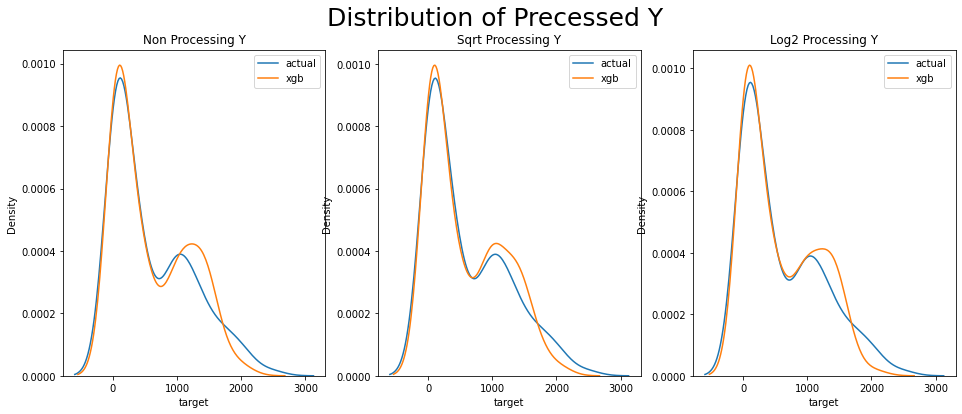

Non Processing Y NMAE :  0.16844303801141838
Sqrt Processing Y NMAE :  0.15800960889139296
Log2 Processing Y NMAE :  0.17307708184139597


In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
fig.suptitle('Distribution of Precessed Y', fontsize= 25)

sns.kdeplot(y_test, ax = ax1).set(title = 'Non Processing Y')
sns.kdeplot(xgb_preds[0], ax = ax1)
ax1.legend(['actual','xgb'])

sns.kdeplot(y_test_sqrt**2, ax = ax2).set(title = 'Sqrt Processing Y')
sns.kdeplot(xgb_preds[1]**2, ax = ax2)
ax2.legend(['actual','xgb'])

sns.kdeplot(2**y_test_log, ax = ax3).set(title = 'Log2 Processing Y')
sns.kdeplot(2**xgb_preds[2], ax = ax3)
ax3.legend(['actual','xgb'])

plt.show()

print('Non Processing Y NMAE : ', nmae(y_test,xgb_preds[0]))
print('Sqrt Processing Y NMAE : ', nmae(y_test_sqrt**2,xgb_preds[1]**2))
print('Log2 Processing Y NMAE : ', nmae(2**y_test_log,2**xgb_preds[2]))

- NMAE 기준 가장 성능이 좋은 처리는 Sqrt 처리
- 그러나, 1000이상 값에 대해 예측 분포의 차이가 실제와 크게 나타남.

## Feature Importance

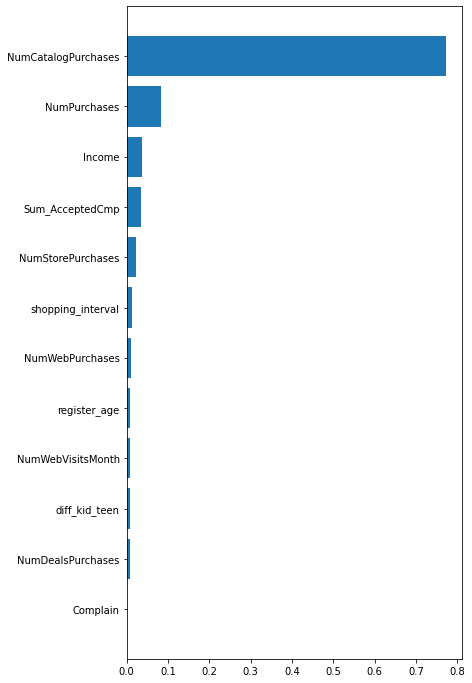

In [42]:
# xgb feature importance
feature_imp = pd.DataFrame(
{
    'feature_name' : in_xgb_features,
    'feat_imp' : val_xgb.feature_importances_
})
feature_imp.sort_values(by = 'feat_imp', ascending=True, inplace=True)

plt.figure(figsize = (6, 12))
plt.barh('feature_name', 'feat_imp', data = feature_imp)
plt.show()

- 하나의 변수(NumCatalogPurchases)에 지나치게 의존하는 경향을 보임.

## Submission Modeling

In [146]:
X_train = train[in_xgb_features]
y_train = np.sqrt(train['target'])

X_test = test[in_xgb_features]

In [147]:
print(X_train.shape, y_train.shape, X_test.shape)

(1108, 12) (1108,) (1108, 12)


In [148]:
xgb = XGBRegressor(random_state = 0)
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)

In [149]:
submission = pd.read_csv(f'{path}/sample_submission.csv')

In [150]:
submission['target'] = [0 if p < 0 else p**2 for p in pred]

In [151]:
submission.head()

,id,target
0,0,530.394549
1,1,741.487106
2,2,787.733117
3,3,1408.913442
4,4,1066.165837


## Submit Prediction

In [152]:
len(in_xgb_features)

12

In [154]:
submission.to_csv(f"{path}/Submissions/xgb_0509_{len(in_xgb_features)}_sqrt.csv", index=False)